# ME449 Homework 2 - Zhengyang Kris Weng submission 10/31/2024

## Part 1:

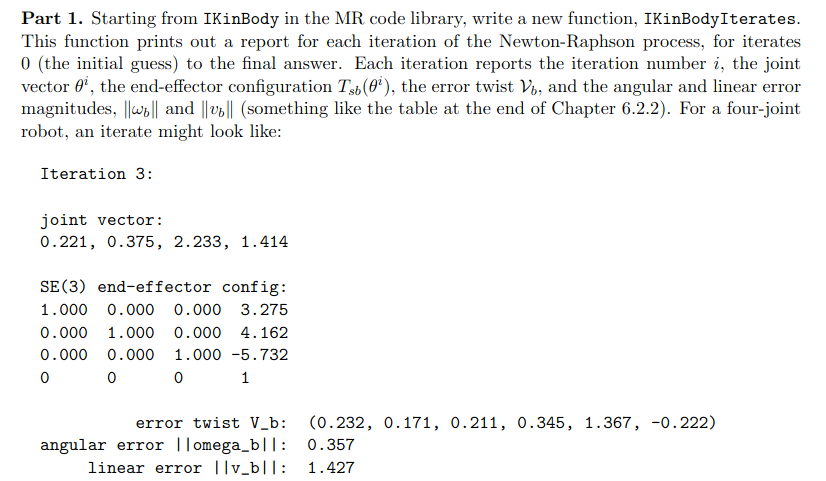

In [42]:
import modern_robotics as mr
import numpy as np
import math

# Set NumPy print options to limit float precision to 2 decimal places
np.set_printoptions(precision=2, suppress=True)
# mr.IKinBody()



In [64]:
# The IKinBodyIterates function:
def IKinBodyIterates(Blist, M, T, thetalist0, eomg, ev):
    """Computes inverse kinematics in the body frame for an open chain robot
       iteratively using newton-raphson method

    :param Blist: The joint screw axes in the end-effector frame when the
                  manipulator is at the home position, in the format of a
                  matrix with axes as the columns
    :param M: The home configuration of the end-effector
    :param T: The desired end-effector configuration Tsd
    :param thetalist0: An initial guess of joint angles that are close to
                       satisfying Tsd
    :param eomg: A small positive tolerance on the end-effector orientation
                 error. The returned joint angles must give an end-effector
                 orientation error less than eomg
    :param ev: A small positive tolerance on the end-effector linear position
               error. The returned joint angles must give an end-effector
               position error less than ev
    :return thetalist: Joint angles that achieve T within the specified
                       tolerances,
    :return success: A logical value where TRUE means that the function found
                     a solution and FALSE means that it ran through the set
                     number of maximum iterations without finding a solution
                     within the tolerances eomg and ev.
    Uses an iterative Newton-Raphson root-finding method.
    The maximum number of iterations before the algorithm is terminated has
    been hardcoded in as a variable called maxiterations. It is set to 20 at
    the start of the function, but can be changed if needed.

    Example Input:
        Blist = np.array([[0, 0, -1, 2, 0,   0],
                          [0, 0,  0, 0, 1,   0],
                          [0, 0,  1, 0, 0, 0.1]]).T
        M = np.array([[-1, 0,  0, 0],
                      [ 0, 1,  0, 6],
                      [ 0, 0, -1, 2],
                      [ 0, 0,  0, 1]])
        T = np.array([[0, 1,  0,     -5],
                      [1, 0,  0,      4],
                      [0, 0, -1, 1.6858],
                      [0, 0,  0,      1]])
        thetalist0 = np.array([1.5, 2.5, 3])
        eomg = 0.01
        ev = 0.001
    Output:
        (np.array([1.57073819, 2.999667, 3.14153913]), True)
    """
    thetalist = np.array(thetalist0).copy()
    i = 0
    maxiterations = 20
    Vb = mr.se3ToVec(mr.MatrixLog6(np.dot(mr.TransInv(mr.FKinBody(M, Blist,
                                                      thetalist)), T)))
    err = np.linalg.norm([Vb[0], Vb[1], Vb[2]]) > eomg \
        or np.linalg.norm([Vb[3], Vb[4], Vb[5]]) > ev
    
    traj = np.array([thetalist])
    ee_pos = np.array(mr.FKinBody(M, Blist, thetalist))[:3,3].T
    err_angle = np.linalg.norm([Vb[0], Vb[1], Vb[2]])
    err_pos = np.linalg.norm([Vb[3], Vb[4], Vb[5]])
    err_list = np.array([err_angle, err_pos])
    

    while err and i < maxiterations:
        thetalist = thetalist \
            + np.dot(np.linalg.pinv(mr.JacobianBody(Blist,
                                                    thetalist)), Vb)
        
        thetalist = [math.atan2(np.sin(theta), np.cos(theta)) for theta in thetalist]
        thetalist = np.array(thetalist)
        
        i = i + 1
        Vb \
            = mr.se3ToVec(mr.MatrixLog6(np.dot(mr.TransInv(mr.FKinBody(M, Blist,
                                                                       thetalist)), T)))
        err = np.linalg.norm([Vb[0], Vb[1], Vb[2]]) > eomg \
            or np.linalg.norm([Vb[3], Vb[4], Vb[5]]) > ev
        
        print(f"Iteration {i}:\n")
        print("joint vector:")
        print(f"{thetalist}\n")
        print("SE(3) end-effector config:\n")
        print(f"{mr.FKinBody(M, Blist, thetalist)}\n")

        print(f"          error twist V_b: {Vb}")
        print(f"angular error ||omega_b||: {np.linalg.norm([Vb[0], Vb[1], Vb[2]])}")
        print(f"     linear error ||v_b||: {np.linalg.norm([Vb[3], Vb[4], Vb[5]])}\n")

        traj = np.vstack([traj, thetalist])
        ee_pos = np.vstack([ee_pos, np.array(mr.FKinBody(M, Blist, thetalist))[:3,3].T])
        err_list = np.vstack([err_list, np.array([np.linalg.norm([Vb[0], Vb[1], Vb[2]]), np.linalg.norm([Vb[3], Vb[4], Vb[5]])])])
        print(f"Trajectory:\n{traj}\n")

    # Save to csv file
    np.savetxt("IKinBodyIterates.csv", traj, delimiter=",")

    return (thetalist, not err, i, traj, ee_pos, err_list)


# Example:
J1_B = np.array([0,0,1,0,3,0])
J2_B = np.array([0,0,1,0,2,0])
J3_B = np.array([0,0,1,0,1,0])

Blist = np.column_stack([J1_B, J2_B, J3_B])

T_sb = np.array([[1, 0, 0, 3],[0,1,0,0],[0,0,1,0],[0,0,0,1]])
T_sd = np.array([[-0.585, -0.811, 0, 0.076],[0.811, -0.585, 0, 2.608],[0,0,1,0],[0,0,0,1]])
result = IKinBodyIterates(Blist, T_sb, T_sd, np.array([np.pi/4, np.pi/4, np.pi/4]), 0.01, 0.001)

Iteration 1:

joint vector:
[0.91 0.63 0.66]

SE(3) end-effector config:

[[-0.59 -0.81  0.    0.06]
 [ 0.81 -0.59  0.    2.6 ]
 [ 0.    0.    1.    0.  ]
 [ 0.    0.    0.    1.  ]]

          error twist V_b: [ 0.    0.   -0.    0.   -0.02  0.  ]
angular error ||omega_b||: 2.898944863771553e-06
     linear error ||v_b||: 0.015631596143492823

Trajectory:
[[0.79 0.79 0.79]
 [0.91 0.63 0.66]]

Iteration 2:

joint vector:
[0.92 0.59 0.68]

SE(3) end-effector config:

[[-0.59 -0.81  0.    0.08]
 [ 0.81 -0.59  0.    2.61]
 [ 0.    0.    1.    0.  ]
 [ 0.    0.    0.    1.  ]]

          error twist V_b: [ 0.  0. -0.  0. -0.  0.]
angular error ||omega_b||: 5.218183997954751e-11
     linear error ||v_b||: 0.00046494374043423795

Trajectory:
[[0.79 0.79 0.79]
 [0.91 0.63 0.66]
 [0.92 0.59 0.68]]



In [90]:
# Construct UR5 Model

# Config:
W1 = 0.109
W2 = 0.082
L1 = 0.425
L2 = 0.392
H1 = 0.089
H2 = 0.095

# Blist:
J1_B = np.array([0, 1, 0, W1+W2, 0, L1+L2])
J2_B = np.array([0, 0, 1, H2, -(L1+L2), 0])
J3_B = np.array([0, 0, 1, H2, -L2, 0])
J4_B = np.array([0, 0, 1, H2, 0, 0])
J5_B = np.array([0, -1, 0, -W2, 0, 0])
J6_B = np.array([0, 0, 1, 0, 0, 0])

# Home config:
M = np.array([[-1, 0, 0, L1+L2], [0, 0, 1, W1+W2],
             [0, 1, 0, H1-H2], [0, 0, 0, 1]])

Blist = np.column_stack([J1_B, J2_B, J3_B, J4_B, J5_B, J6_B])

T_sd = np.array([[1, 0, 0, 0.3], [0, 1, 0, 0.3], [0, 0, 1, 0.4], [0, 0, 0, 1]])


# wrap answers from -2pi to 2pi
def wrap_joint_range(thetalist):
    for i in range(len(thetalist)):
        thetalist[i] = thetalist[i] % (2*np.pi)
    return thetalist

Now, testing out the new function:

In [91]:
init_guess_bad = np.array([-0.4, -5, -2, -1, -1, 0])
init_guess_good = np.array([0.5, 0.3, 4.0, 3.0, 4.5, 1.0])

result_bad = IKinBodyIterates(Blist, M, T_sd, init_guess_bad, 0.0001, 0.001)

print(f"Joint angles for bad guess: {result_bad[0]}. It took {result_bad[2]} iterations to converge.\n")

# Plot a 3d trajectory of the joint angles
def plot_trajectory(bad_ee, good_ee):
    import matplotlib.pyplot as plt
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(bad_ee[:,0], bad_ee[:,1], bad_ee[:,2], label='bad guess')
    ax.plot(good_ee[:,0], good_ee[:,1], good_ee[:,2], label='good guess')
    ax.plot(bad_ee[-1,0], bad_ee[-1,1], bad_ee[-1,2], 'x', label='end')
    ax.plot(bad_ee[0,0], bad_ee[0,1], bad_ee[0,2], 'o', label='start of bad guess')
    ax.plot(good_ee[0,0], good_ee[0,1], good_ee[0,2], 'o', label='start of good guess')
    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')
    ax.set_zlabel('z (m)')
    ax.legend()
    ax.set_title('End-effector trajectory')
    plt.show()


def plot_pos_error(err_list_bad, err_list_good):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots()
    ax.plot(err_list_bad[:,1], label='bad guess')
    ax.plot(err_list_good[:,1], label='good guess')
    ax.set_xlabel('iteration')
    ax.set_ylabel('linear error')
    ax.legend()
    ax.set_title('Linear error vs iteration')
    plt.show()

def plot_angular_error(err_list_bad, err_list_good):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots()
    ax.plot(err_list_bad[:,0], label='bad guess')
    ax.plot(err_list_good[:,0], label='good guess')
    ax.set_xlabel('iteration')
    ax.set_ylabel('angular error')
    ax.legend()
    ax.set_title('Angular error vs iteration')
    plt.show()


Iteration 1:

joint vector:
[ 0.81  1.53 -1.87  2.39  0.94  2.11]

SE(3) end-effector config:

[[ 0.73  0.03 -0.68  0.07]
 [ 0.17 -0.98  0.14  0.31]
 [-0.66 -0.21 -0.72 -0.22]
 [ 0.    0.    0.    1.  ]]

          error twist V_b: [ 2.74  0.16 -1.08  0.07 -0.97  0.07]
angular error ||omega_b||: 2.9527846944857012
     linear error ||v_b||: 0.9767389130075668

Trajectory:
[[-0.4  -5.   -2.   -1.   -1.    0.  ]
 [ 0.81  1.53 -1.87  2.39  0.94  2.11]]

Iteration 2:

joint vector:
[ 2.58 -0.72 -0.42  0.14 -2.15 -2.18]

SE(3) end-effector config:

[[-0.7  -0.25  0.67 -0.48]
 [-0.13  0.97  0.23  0.22]
 [-0.7   0.07 -0.71  0.62]
 [ 0.    0.    0.    1.  ]]

          error twist V_b: [ 0.27 -2.35 -0.21  0.64 -0.03  0.82]
angular error ||omega_b||: 2.374954220531417
     linear error ||v_b||: 1.0395124861318912

Trajectory:
[[-0.4  -5.   -2.   -1.   -1.    0.  ]
 [ 0.81  1.53 -1.87  2.39  0.94  2.11]
 [ 2.58 -0.72 -0.42  0.14 -2.15 -2.18]]

Iteration 3:

joint vector:
[ 2.51 -2.37 -1.92 -0.56

Iteration 1:

joint vector:
[ 0.51  0.43 -1.67  2.83 -1.59  1.12]

SE(3) end-effector config:

[[ 1.   -0.06  0.02  0.31]
 [ 0.06  1.   -0.01  0.3 ]
 [-0.02  0.01  1.    0.37]
 [ 0.    0.    0.    1.  ]]

          error twist V_b: [-0.01 -0.02 -0.06 -0.01  0.    0.03]
angular error ||omega_b||: 0.06586899104348297
     linear error ||v_b||: 0.03607246766369

Trajectory:
[[ 0.5   0.3   4.    3.    4.5   1.  ]
 [ 0.51  0.43 -1.67  2.83 -1.59  1.12]]

Iteration 2:

joint vector:
[ 0.52  0.36 -1.66  2.87 -1.57  1.05]

SE(3) end-effector config:

[[ 1.   0.  -0.   0.3]
 [-0.   1.  -0.   0.3]
 [ 0.   0.   1.   0.4]
 [ 0.   0.   0.   1. ]]

          error twist V_b: [-0.  0.  0.  0.  0.  0.]
angular error ||omega_b||: 0.00115005379318028
     linear error ||v_b||: 0.001500755483736736

Trajectory:
[[ 0.5   0.3   4.    3.    4.5   1.  ]
 [ 0.51  0.43 -1.67  2.83 -1.59  1.12]
 [ 0.52  0.36 -1.66  2.87 -1.57  1.05]]

Iteration 3:

joint vector:
[ 0.53  0.36 -1.65  2.87 -1.57  1.05]

SE(3) end-

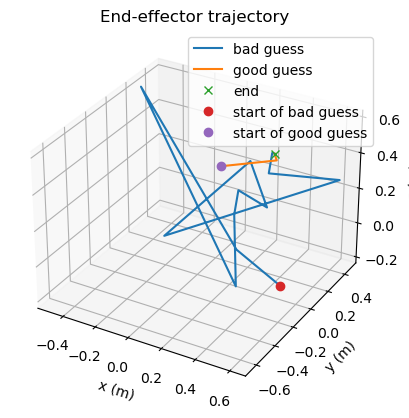

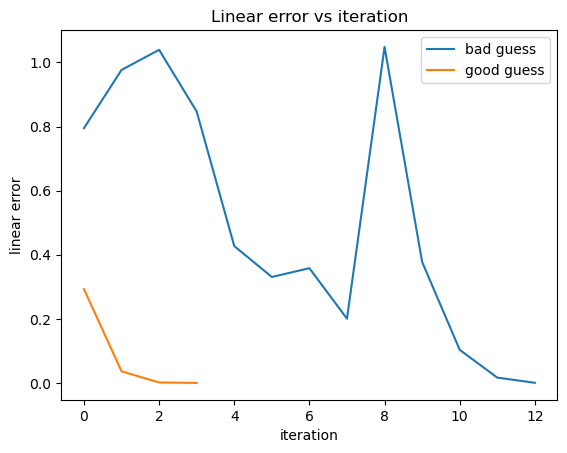

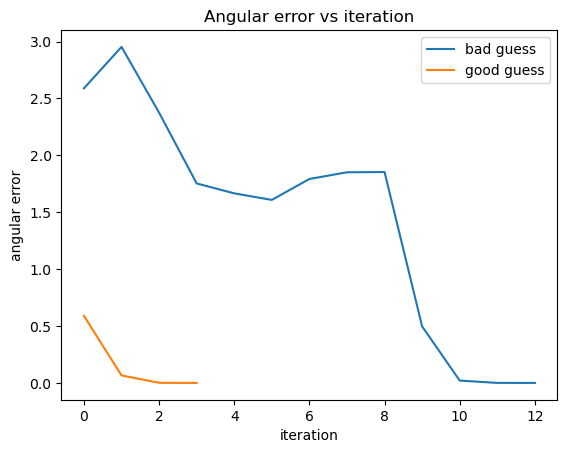

In [92]:
result_good = IKinBodyIterates(Blist, M, T_sd, init_guess_good, 0.0001, 0.001)
# joint_list_good = wrap_joint_range(result_good[0])
print(f"Joint angles for good guess: {result_good[0]}. It took {result_good[2]} iterations to converge.\n") 
plot_trajectory(result_bad[4], result_good[4])
plot_pos_error(result_bad[5], result_good[5])
plot_angular_error(result_bad[5], result_good[5])

## Part 2: